In [1]:
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score, roc_curve


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


from tqdm import tqdm
import matplotlib.pyplot as plt             #visualisation
import seaborn as sns   #visualisation
from torch.utils.tensorboard import SummaryWriter
%matplotlib inline     
sns.set(color_codes=True)

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    raise Exception("Cry about it")


In [3]:
import torch.nn.functional as F
import math

class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.view(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
        
        output = output.view(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

In [4]:
def add_cell_prefix(df, prefix):
    df.index = [prefix + i for i in df.index]
    return df

#Remove extra quotes from the filenames
def extract_cell_name_smartseq(x):
    y = x.split("_")
    return y[len(y)-2]

def get_cell_name_smartseq(file_name):
    return extract_cell_name_smartseq(file_name)

def convert_indexes_to_cell_names_smartseq(df):
    df.index = [get_cell_name_smartseq(x) for x in df.index]
    return df

def get_cell_hypo_or_norm_smartseq(df_meta, cell_name):
    return df_meta[df_meta["Cell name"]==cell_name]["Condition"].values[0]

def seperate_hypo_and_norm_smartseq(df, df_meta):
    df_hypo = df[df.index.map(lambda x: get_cell_hypo_or_norm_smartseq(df_meta, x)=="Hypo")]
    df_norm = df[df.index.map(lambda x: get_cell_hypo_or_norm_smartseq(df_meta, x)=="Norm" or get_cell_hypo_or_norm_smartseq(df_meta, x)=="Normo")]
    return df_hypo, df_norm

def process_df_smartseq(df, df_meta, prefix):
    df = convert_indexes_to_cell_names_smartseq(df)
    _, df_norm = seperate_hypo_and_norm_smartseq(df,df_meta)
    df = add_cell_prefix(df, prefix)
    df_norm = add_cell_prefix(df_norm, prefix)
    return df, df_norm.index

#Remove extra quotes from the filenames
def extract_cell_name_dropseq(x):
    y = x.split("_")
    return y[0]

def get_cell_name_dropseq(file_name):
    return extract_cell_name_dropseq(file_name)

def convert_indexes_to_cell_names_dropseq(df):
    df.index = [get_cell_name_dropseq(x) for x in df.index]
    return df

def get_cell_hypo_or_norm_dropseq(cell_name):
    return cell_name.split("_")[-1]

def seperate_hypo_and_norm_dropseq(df):
    df_hypo = df[df.index.map(lambda x: get_cell_hypo_or_norm_dropseq(x)=="Hypoxia")]
    df_norm = df[df.index.map(lambda x: get_cell_hypo_or_norm_dropseq(x)=="Normoxia")]
    return df_hypo, df_norm

def process_df_dropseq(df, prefix):
    _, df_norm = seperate_hypo_and_norm_dropseq(df)
    df = convert_indexes_to_cell_names_dropseq(df)
    df_norm = convert_indexes_to_cell_names_dropseq(df_norm)
    df = add_cell_prefix(df, prefix)
    df_norm = add_cell_prefix(df_norm, prefix)
    return df, df_norm.index

In [5]:
df_meta = pd.read_csv("Data/SmartSeq/MCF7_SmartS_MetaData.tsv",delimiter="\t", index_col=0)
dffn = pd.read_csv("Data/SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
df2_meta = pd.read_csv("Data/SmartSeq/HCC1806_SmartS_MetaData.tsv",delimiter="\t",index_col=0)
df2fn = pd.read_csv("Data/SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
df3 = pd.read_csv("Data/DropSeq/MCF7_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
df4 = pd.read_csv("Data/DropSeq/HCC1806_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T

In [6]:
dffn, dffn_norm_idx = process_df_smartseq(dffn.copy(), df_meta, "MCF7_")
df2fn, df2fn_norm_idx = process_df_smartseq(df2fn.copy(), df2_meta, "HCC1806_")
df3, df3_norm_idx = process_df_dropseq(df3, "MCF7_")
df4, df4_norm_idx = process_df_dropseq(df4, "HCC1806_")

In [7]:
df3

,MALAT1,MT-RNR2,NEAT1,H1-5,TFF1,MT-RNR1,H4C3,GDF15,KRT81,MT-CO3,...,MROH1,SKIDA1,MICALL1,RARG,MYO1F,BRWD1-AS2,RPS19BP1,AUNIP,TNK2,SUDS3
MCF7_AAAAACCTATCG,1,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MCF7_AAAACAACCCTA,3,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MCF7_AAAACACTCTCA,3,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MCF7_AAAACCAGGCAC,6,2,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MCF7_AAAACCTAGCTC,4,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MCF7_TTTTCGCGTAGA,0,0,0,0,3,0,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MCF7_TTTTCGTCCGCT,1,0,0,0,4,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
MCF7_TTTTCTCCGGCT,0,0,0,1,2,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,1
MCF7_TTTTGTTCAAAG,0,0,0,0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df_drop_norm_idx = np.concatenate([df3_norm_idx, df4_norm_idx])
df_smart_norm_idx = np.concatenate([dffn_norm_idx, df2fn_norm_idx])
df_smart_idx = np.concatenate([dffn.index, df2fn.index])

df_all = pd.concat([dffn, df2fn, df3, df4])
df_all = df_all.fillna(-1)

df_all_norm_idx = np.concatenate([dffn_norm_idx, df2fn_norm_idx, df3_norm_idx, df4_norm_idx])

df_MCF7_idx = [idx for idx in df_all.index if "MCF7" in idx]


In [9]:
df_all = df_all.astype(np.int32)

In [10]:
# Free up memory
del dffn, df2fn, df3, df4, dffn_norm_idx, df2fn_norm_idx, df3_norm_idx, df4_norm_idx, df_meta, df2_meta

In [87]:
class NNDataset(Dataset):
    def __init__(self, df, df_norm_idx):
        self.data = df.values  # Convert DataFrame to numpy array
        self.data_norm = df_norm_idx
        self.idx = df.index
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        dat = self.data[index, :]
        x = torch.tensor(dat, dtype=torch.float32, device=device)
        y = torch.tensor(0 if self.idx[index] in self.data_norm else 1,  dtype=torch.float32, device=device)
        return x, y

# Define the architecture of the autoencoder
class NNClassifier(nn.Module):
    def __init__(self, in_size, H1, H2, H3):
        super(NNClassifier, self).__init__()

        self.layers = nn.Sequential(
            KANLinear(in_size, H1),
            nn.Dropout(0.5),
            KANLinear(H1, 1))

    def forward(self, x):
        return self.layers(x)

In [12]:
@torch.no_grad
def measure_model_log(writer, model, data_loader, epoch):
    correct = 0
    total = 0
    y_pred = []
    y_pred_class = []
    y_true = []
    for inputs, labels in data_loader:
        outputs = model(inputs)
        predicted = nn.Sigmoid()(outputs[:, 0])
        total += labels.size(0)
        correct += (predicted.round() == labels).sum().item()
        y_pred_class.extend(predicted.cpu().round().numpy()) # Save Prediction
        y_pred.extend(predicted.cpu().numpy()) # Save Prediction
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
    if(np.isnan(y_pred_class).any()):
        print("Found nan, skipping evaluation")
        return 
    f1 = f1_score(y_true, y_pred_class)
    recall = recall_score(y_true, y_pred_class)
    accuracy = (correct / total)
    writer.add_scalar("F1 Score", f1, epoch)
    writer.add_scalar("Recall", recall, epoch)
    writer.add_scalar("Accuracy", accuracy, epoch)
    print("F1 Score:", f1)
    print("Recall:", recall)
    print(f'Accuracy on test: {accuracy * 100}%')

    # constant for classes
    classes = ('Normoxia', 'Hypoxia')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred_class)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
    fig = plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)
    writer.add_figure("Confusion Matrix", fig, epoch)

    fig = plt.figure(figsize = (12,7))
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    writer.add_figure("ROC Curve", fig, epoch)


@torch.no_grad
def measure_model(model, data_loader):
    plt.close()
    correct = 0
    total = 0
    y_pred = []
    y_pred_class = []
    y_true = []
    for inputs, labels in data_loader:
        outputs = model(inputs)
        predicted = nn.Sigmoid()(outputs[:, 0])
        total += labels.size(0)
        correct += (predicted.round() == labels).sum().item()
        y_pred_class.extend(predicted.cpu().round().numpy()) # Save Prediction
        y_pred.extend(predicted.cpu().numpy()) # Save Prediction
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
    
    # constant for classes
    classes = ('Normoxia', 'Hypoxia')

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred_class)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)
    f1 = f1_score(y_true, y_pred_class)
    recall = recall_score(y_true, y_pred_class)
    accuracy = (correct / total)
    print("F1 Score:", f1)
    print("Recall:", recall)
    print(f'Accuracy on test: {accuracy * 100}%')


In [88]:
input_size = 3000
learning_rate = 1e-2

hidden_size = 1024
hidden_size1 = 512
hidden_size2 = 256

test_amount = 0.2

In [14]:
df_train, df_test = train_test_split(df_all, test_size=test_amount, stratify=df_all.index.isin(df_all_norm_idx))
df_train = df_train.replace(-1, None)
df_test = df_test.replace(-1, None)

In [31]:
df_train_smart_mcf = df_train[[(i in df_smart_idx) and (i in df_MCF7_idx) for i in df_train.index]].dropna(axis=1).astype(np.int32)
df_train_smart_hcc = df_train[[(i in df_smart_idx) and (i not in df_MCF7_idx) for i in df_train.index]].dropna(axis=1).astype(np.int32)
df_train_drop_mcf = df_train[[(i not in df_smart_idx) and (i in df_MCF7_idx) for i in df_train.index]].dropna(axis=1).astype(np.int32)
df_train_drop_hcc = df_train[[(i not in df_smart_idx) and (i not in df_MCF7_idx) for i in df_train.index]].dropna(axis=1).astype(np.int32)

dataset_smart_mcf = NNDataset(df_train_smart_mcf, df_all_norm_idx)
dataset_smart_hcc = NNDataset(df_train_smart_hcc, df_all_norm_idx)
dataset_drop_mcf = NNDataset(df_train_drop_mcf, df_all_norm_idx)
dataset_drop_hcc = NNDataset(df_train_drop_hcc, df_all_norm_idx)

data_loader_smart_mcf = DataLoader(dataset_smart_mcf, batch_size=32, shuffle=True)
data_loader_smart_hcc = DataLoader(dataset_smart_hcc, batch_size=32, shuffle=True)
data_loader_drop_mcf = DataLoader(dataset_drop_mcf, batch_size=128, shuffle=True)
data_loader_drop_hcc = DataLoader(dataset_drop_hcc, batch_size=128, shuffle=True)

In [32]:
df_test_smart_mcf = df_test[[(i in df_smart_idx) and (i in df_MCF7_idx) for i in df_test.index]].dropna(axis=1).astype(np.int32)
df_test_smart_hcc = df_test[[(i in df_smart_idx) and (i not in df_MCF7_idx) for i in df_test.index]].dropna(axis=1).astype(np.int32)
df_test_drop_mcf = df_test[[(i not in df_smart_idx) and (i in df_MCF7_idx) for i in df_test.index]].dropna(axis=1).astype(np.int32)
df_test_drop_hcc = df_test[[(i not in df_smart_idx) and (i not in df_MCF7_idx) for i in df_test.index]].dropna(axis=1).astype(np.int32)

dataset_test_smart_mcf = NNDataset(df_test_smart_mcf, df_all_norm_idx)
dataset_test_smart_hcc = NNDataset(df_test_smart_hcc, df_all_norm_idx)
dataset_test_drop_mcf = NNDataset(df_test_drop_mcf, df_all_norm_idx)
dataset_test_drop_hcc = NNDataset(df_test_drop_hcc, df_all_norm_idx)

test_loader_smart_mcf = DataLoader(dataset_test_smart_mcf, batch_size=32, shuffle=True)
test_loader_smart_hcc = DataLoader(dataset_test_smart_hcc, batch_size=32, shuffle=True)
test_loader_drop_mcf = DataLoader(dataset_test_drop_mcf, batch_size=128, shuffle=True)
test_loader_drop_hcc = DataLoader(dataset_test_drop_hcc, batch_size=128, shuffle=True)

In [89]:
# Define the model
model = NNClassifier(input_size, hidden_size, hidden_size1, hidden_size2).to(device)
writer = SummaryWriter()

In [90]:
# Define the loss function
criterion = nn.BCEWithLogitsLoss()


In [91]:
lr_sgd = 1e-2
lr_adm = 1e-3
lr_ada = 1e-2
lr_admw = 1e-3
wd_admw = 1e-4

# Define the optimizer
sgd = optim.SGD(model.parameters(), lr=lr_sgd)
adm = optim.Adam(model.parameters(), lr=lr_adm)
ada = optim.Adagrad(model.parameters(), lr=lr_ada)
admw = optim.AdamW(model.parameters(), lr=lr_admw, weight_decay=wd_admw)

In [92]:
model

NNClassifier(
  (layers): Sequential(
    (0): KANLinear(
      (base_activation): SiLU()
    )
    (1): Dropout(p=0.5, inplace=False)
    (2): KANLinear(
      (base_activation): SiLU()
    )
  )
)

In [101]:
train_config = [
    #[5, data_loader, admw],
    [100, data_loader_drop_hcc, test_loader_drop_hcc, adm]
]

In [102]:
total_epochs = 0
# Training loop
for segment in train_config:
    num_epochs = segment[0]
    data_loaderr = segment[1]
    test_loaderr = segment[2]
    optimizer = segment[3]
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        for inputs, labels in data_loaderr:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            # Compute loss
            loss = criterion(outputs[:, 0], labels)

            # Backward pass and optimize
            loss.backward()

            # Clip gradients
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            # Print statistics
            running_loss += loss.item()

        writer.add_scalar("Loss/train", running_loss/len(data_loaderr), epoch)
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(data_loaderr)}", flush=True)
        measure_model_log(writer, model, test_loaderr, total_epochs)
        writer.flush()
        total_epochs += 1

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Loss: 0.4380972447663384


  1%|          | 1/100 [00:06<10:45,  6.52s/it]

F1 Score: 0.947980238302819
Recall: 0.9240793201133144
Accuracy on test: 93.86145404663924%
Epoch 2, Loss: 0.08956542294269995


  2%|▏         | 2/100 [00:13<10:37,  6.51s/it]

F1 Score: 0.9575118022771453
Recall: 0.976770538243626
Accuracy on test: 94.75308641975309%
Epoch 3, Loss: 0.036461202199975756


  3%|▎         | 3/100 [00:19<10:31,  6.51s/it]

F1 Score: 0.9626089401180771
Recall: 0.969971671388102
Accuracy on test: 95.43895747599451%
Epoch 4, Loss: 0.020190336075915104


  4%|▍         | 4/100 [00:26<10:24,  6.51s/it]

F1 Score: 0.9610971172684019
Recall: 0.9728045325779037
Accuracy on test: 95.23319615912207%
Epoch 5, Loss: 0.011262043150212698


  5%|▌         | 5/100 [00:32<10:19,  6.52s/it]

F1 Score: 0.9608011444921316
Recall: 0.9512747875354107
Accuracy on test: 95.30178326474623%
Epoch 6, Loss: 0.007664217809771957


  6%|▌         | 6/100 [00:39<10:12,  6.52s/it]

F1 Score: 0.9654195011337868
Recall: 0.964872521246459
Accuracy on test: 95.81618655692729%
Epoch 7, Loss: 0.006009443074657136


  7%|▋         | 7/100 [00:45<10:06,  6.52s/it]

F1 Score: 0.9625457617572515
Recall: 0.968271954674221
Accuracy on test: 95.43895747599451%
Epoch 8, Loss: 0.004183296284400453


  8%|▊         | 8/100 [00:52<10:00,  6.53s/it]

F1 Score: 0.9615166949632145
Recall: 0.9626062322946176
Accuracy on test: 95.33607681755831%
Epoch 9, Loss: 0.0036410328146935763


  9%|▉         | 9/100 [00:58<09:54,  6.54s/it]

F1 Score: 0.9641748942172074
Recall: 0.968271954674221
Accuracy on test: 95.64471879286694%
Epoch 10, Loss: 0.0026245460331151466


 10%|█         | 10/100 [01:05<09:48,  6.54s/it]

F1 Score: 0.963256076879593
Recall: 0.9654390934844193
Accuracy on test: 95.54183813443072%
Epoch 11, Loss: 0.0014468727496695583


 11%|█         | 11/100 [01:11<09:41,  6.53s/it]

F1 Score: 0.9648326715825298
Recall: 0.9637393767705382
Accuracy on test: 95.74759945130316%
Epoch 12, Loss: 0.0014968130607208561


 12%|█▏        | 12/100 [01:18<09:35,  6.54s/it]

F1 Score: 0.9671760045274477
Recall: 0.968271954674221
Accuracy on test: 96.02194787379973%
Epoch 13, Loss: 0.0016639529478751406


 13%|█▎        | 13/100 [01:24<09:28,  6.53s/it]

F1 Score: 0.9632144878324844
Recall: 0.9643059490084985
Accuracy on test: 95.54183813443072%
Epoch 14, Loss: 0.0011428672279061689


 14%|█▍        | 14/100 [01:31<09:22,  6.54s/it]

F1 Score: 0.9643866591294517
Recall: 0.96657223796034
Accuracy on test: 95.67901234567901%
Epoch 15, Loss: 0.001015901552660659


 15%|█▌        | 15/100 [01:37<09:15,  6.53s/it]

F1 Score: 0.9612359550561798
Recall: 0.9694050991501416
Accuracy on test: 95.26748971193416%
Epoch 16, Loss: 0.0007927944317761221


 16%|█▌        | 16/100 [01:44<09:08,  6.53s/it]

F1 Score: 0.9675965060580445
Recall: 0.9728045325779037
Accuracy on test: 96.0562414266118%
Epoch 17, Loss: 0.0009696151170393695


 17%|█▋        | 17/100 [01:50<09:01,  6.53s/it]

F1 Score: 0.9634831460674157
Recall: 0.9716713881019831
Accuracy on test: 95.54183813443072%
Epoch 18, Loss: 0.0007854597728431185


 18%|█▊        | 18/100 [01:57<08:55,  6.53s/it]

F1 Score: 0.964951950254381
Recall: 0.9671388101983003
Accuracy on test: 95.74759945130316%
Epoch 19, Loss: 0.0006250726669152399


 19%|█▉        | 19/100 [02:04<08:49,  6.54s/it]

F1 Score: 0.9627329192546584
Recall: 0.9660056657223796
Accuracy on test: 95.47325102880659%
Epoch 20, Loss: 0.0004459931040638248


 20%|██        | 20/100 [02:10<08:43,  6.54s/it]

F1 Score: 0.9649717514124294
Recall: 0.9677053824362606
Accuracy on test: 95.74759945130316%
Epoch 21, Loss: 0.0004426791093346369


 21%|██        | 21/100 [02:17<08:37,  6.55s/it]

F1 Score: 0.9652836579170194
Recall: 0.9688385269121813
Accuracy on test: 95.78189300411523%
Epoch 22, Loss: 0.0003238594353324911


 22%|██▏       | 22/100 [02:23<08:31,  6.55s/it]

F1 Score: 0.963256076879593
Recall: 0.9654390934844193
Accuracy on test: 95.54183813443072%
Epoch 23, Loss: 0.0004989077250802834


 23%|██▎       | 23/100 [02:30<08:24,  6.55s/it]

F1 Score: 0.9625879043600563
Recall: 0.9694050991501416
Accuracy on test: 95.43895747599451%
Epoch 24, Loss: 0.0006423643723357362


 24%|██▍       | 24/100 [02:36<08:17,  6.55s/it]

F1 Score: 0.965595678134774
Recall: 0.9620396600566572
Accuracy on test: 95.85048010973937%
Epoch 25, Loss: 0.0005607989062453904


 25%|██▌       | 25/100 [02:43<08:10,  6.54s/it]

F1 Score: 0.9635445877734156
Recall: 0.973371104815864
Accuracy on test: 95.54183813443072%
Epoch 26, Loss: 0.000500231686522096


 26%|██▌       | 26/100 [02:49<08:03,  6.54s/it]

F1 Score: 0.9651459336922641
Recall: 0.964872521246459
Accuracy on test: 95.78189300411523%
Epoch 27, Loss: 0.00040391770594199085


 27%|██▋       | 27/100 [02:56<07:57,  6.54s/it]

F1 Score: 0.9638213680045223
Recall: 0.9660056657223796
Accuracy on test: 95.61042524005488%
Epoch 28, Loss: 0.000352582837204745
F1 Score: 0.9663817663817664
Recall: 0.9609065155807366
Accuracy on test: 95.95336076817559%


 28%|██▊       | 28/100 [03:03<08:08,  6.79s/it]

Epoch 29, Loss: 0.0003634339723841707


 29%|██▉       | 29/100 [03:10<07:57,  6.72s/it]

F1 Score: 0.9640852974186308
Recall: 0.973371104815864
Accuracy on test: 95.61042524005488%
Epoch 30, Loss: 0.00022702974832139697


 30%|███       | 30/100 [03:16<07:46,  6.67s/it]

F1 Score: 0.963923337091319
Recall: 0.9688385269121813
Accuracy on test: 95.61042524005488%
Epoch 31, Loss: 0.00022284189890342532


 31%|███       | 31/100 [03:23<07:38,  6.64s/it]

F1 Score: 0.9638896787034404
Recall: 0.9603399433427762
Accuracy on test: 95.64471879286694%
Epoch 32, Loss: 0.00018387416118615795


 32%|███▏      | 32/100 [03:30<07:29,  6.61s/it]

F1 Score: 0.9640532125672233
Recall: 0.964872521246459
Accuracy on test: 95.64471879286694%
Epoch 33, Loss: 0.00013130564085535613


 33%|███▎      | 33/100 [03:36<07:21,  6.59s/it]

F1 Score: 0.9672501411631846
Recall: 0.9705382436260623
Accuracy on test: 96.02194787379973%
Epoch 34, Loss: 0.0002121237134617885


 34%|███▍      | 34/100 [03:43<07:13,  6.57s/it]

F1 Score: 0.9621682665160926
Recall: 0.9654390934844193
Accuracy on test: 95.40466392318244%
Epoch 35, Loss: 0.00017552603910940968


 35%|███▌      | 35/100 [03:49<07:06,  6.56s/it]

F1 Score: 0.9648924122310306
Recall: 0.9654390934844193
Accuracy on test: 95.74759945130316%
Epoch 36, Loss: 0.00038047843700832857


 36%|███▌      | 36/100 [03:56<06:59,  6.55s/it]

F1 Score: 0.9643158190502951
Recall: 0.9722379603399434
Accuracy on test: 95.64471879286694%
Epoch 37, Loss: 0.0022092368060681188


 37%|███▋      | 37/100 [04:02<06:52,  6.55s/it]

F1 Score: 0.9632583309598405
Recall: 0.9580736543909348
Accuracy on test: 95.57613168724279%
Epoch 38, Loss: 0.00444125414615764


 38%|███▊      | 38/100 [04:09<06:44,  6.53s/it]

F1 Score: 0.9600456621004566
Recall: 0.9529745042492918
Accuracy on test: 95.19890260631001%
Epoch 39, Loss: 0.003954266488780495


 39%|███▉      | 39/100 [04:15<06:38,  6.53s/it]

F1 Score: 0.9606741573033708
Recall: 0.9688385269121813
Accuracy on test: 95.19890260631001%
Epoch 40, Loss: 0.0027117949026116707


 40%|████      | 40/100 [04:22<06:31,  6.53s/it]

F1 Score: 0.9600674915635545
Recall: 0.9671388101983003
Accuracy on test: 95.13031550068587%
Epoch 41, Loss: 0.0013159088293437178


 41%|████      | 41/100 [04:28<06:24,  6.52s/it]

F1 Score: 0.9623717217787914
Recall: 0.9563739376770538
Accuracy on test: 95.47325102880659%
Epoch 42, Loss: 0.0016051467327206806


 42%|████▏     | 42/100 [04:35<06:18,  6.52s/it]

F1 Score: 0.9626674266172699
Recall: 0.9569405099150141
Accuracy on test: 95.50754458161865%
Epoch 43, Loss: 0.0013649762510557712


 43%|████▎     | 43/100 [04:41<06:11,  6.52s/it]

F1 Score: 0.9621190544004558
Recall: 0.9569405099150141
Accuracy on test: 95.43895747599451%
Epoch 44, Loss: 0.002532409242062188


 44%|████▍     | 44/100 [04:48<06:04,  6.52s/it]

F1 Score: 0.9620611551528879
Recall: 0.9626062322946176
Accuracy on test: 95.40466392318244%
Epoch 45, Loss: 0.0038617095560766757


 45%|████▌     | 45/100 [04:54<05:58,  6.51s/it]

F1 Score: 0.9628378378378378
Recall: 0.9688385269121813
Accuracy on test: 95.47325102880659%
Epoch 46, Loss: 0.0014271592783643428


 46%|████▌     | 46/100 [05:01<05:51,  6.51s/it]

F1 Score: 0.9676320272572402
Recall: 0.9654390934844193
Accuracy on test: 96.09053497942386%
Epoch 47, Loss: 0.001026812590917752


 47%|████▋     | 47/100 [05:07<05:45,  6.52s/it]

F1 Score: 0.9596886294134
Recall: 0.9779036827195468
Accuracy on test: 95.02743484224966%
Epoch 48, Loss: 0.0007965838428746159


 48%|████▊     | 48/100 [05:14<05:39,  6.52s/it]

F1 Score: 0.9656932237028636
Recall: 0.964872521246459
Accuracy on test: 95.85048010973937%
Epoch 49, Loss: 0.00022161496890080542


 49%|████▉     | 49/100 [05:20<05:33,  6.54s/it]

F1 Score: 0.9655172413793104
Recall: 0.9677053824362606
Accuracy on test: 95.81618655692729%
Epoch 50, Loss: 0.00017717440244308344


 50%|█████     | 50/100 [05:27<05:27,  6.55s/it]

F1 Score: 0.9650507328072153
Recall: 0.969971671388102
Accuracy on test: 95.74759945130316%
Epoch 51, Loss: 0.000147820672682626


 51%|█████     | 51/100 [05:34<05:21,  6.55s/it]

F1 Score: 0.9630261660978384
Recall: 0.9592067988668556
Accuracy on test: 95.54183813443072%
Epoch 52, Loss: 0.00027839444552900323


 52%|█████▏    | 52/100 [05:40<05:14,  6.55s/it]

F1 Score: 0.9631712116952488
Recall: 0.9705382436260623
Accuracy on test: 95.50754458161865%
Epoch 53, Loss: 0.00013350828109660932


 53%|█████▎    | 53/100 [05:47<05:08,  6.56s/it]

F1 Score: 0.9625035241048774
Recall: 0.9671388101983003
Accuracy on test: 95.43895747599451%
Epoch 54, Loss: 8.817213265304062e-05
F1 Score: 0.9620611551528879
Recall: 0.9626062322946176
Accuracy on test: 95.40466392318244%


 54%|█████▍    | 54/100 [05:54<05:05,  6.65s/it]

Epoch 55, Loss: 0.0001894590947477295


 55%|█████▌    | 55/100 [06:00<04:57,  6.61s/it]

F1 Score: 0.9642755072877965
Recall: 0.9558073654390935
Accuracy on test: 95.71330589849109%
Epoch 56, Loss: 0.0003059542448919155


 56%|█████▌    | 56/100 [06:07<04:49,  6.58s/it]

F1 Score: 0.9635901778154107
Recall: 0.9671388101983003
Accuracy on test: 95.57613168724279%
Epoch 57, Loss: 0.0004436802854076197


 57%|█████▋    | 57/100 [06:13<04:42,  6.57s/it]

F1 Score: 0.9628790025502976
Recall: 0.9626062322946176
Accuracy on test: 95.50754458161865%
Epoch 58, Loss: 0.0009624407995607212


 58%|█████▊    | 58/100 [06:20<04:35,  6.57s/it]

F1 Score: 0.9626299522337736
Recall: 0.9705382436260623
Accuracy on test: 95.43895747599451%
Epoch 59, Loss: 0.0008362542635930605


 59%|█████▉    | 59/100 [06:26<04:29,  6.56s/it]

F1 Score: 0.963677639046538
Recall: 0.9620396600566572
Accuracy on test: 95.61042524005488%
Epoch 60, Loss: 0.0001891857128617116


 60%|██████    | 60/100 [06:33<04:22,  6.55s/it]

F1 Score: 0.9632144878324844
Recall: 0.9643059490084985
Accuracy on test: 95.54183813443072%
Epoch 61, Loss: 0.00033225037188221114


 61%|██████    | 61/100 [06:39<04:14,  6.53s/it]

F1 Score: 0.9631519274376418
Recall: 0.9626062322946176
Accuracy on test: 95.54183813443072%
Epoch 62, Loss: 0.0008309969837919989


 62%|██████▏   | 62/100 [06:46<04:07,  6.52s/it]

F1 Score: 0.9618451025056948
Recall: 0.9569405099150141
Accuracy on test: 95.40466392318244%
Epoch 63, Loss: 0.00023812182556194665


 63%|██████▎   | 63/100 [06:52<04:01,  6.53s/it]

F1 Score: 0.9635854341736695
Recall: 0.9745042492917847
Accuracy on test: 95.54183813443072%
Epoch 64, Loss: 0.0017757729206936267


 64%|██████▍   | 64/100 [06:59<03:55,  6.55s/it]

F1 Score: 0.9583815028901734
Recall: 0.9393767705382436
Accuracy on test: 95.06172839506173%
Epoch 65, Loss: 0.0014085849633691237


 65%|██████▌   | 65/100 [07:05<03:49,  6.56s/it]

F1 Score: 0.9625638116846285
Recall: 0.9614730878186969
Accuracy on test: 95.47325102880659%
Epoch 66, Loss: 0.0006356771549215647


 66%|██████▌   | 66/100 [07:12<03:42,  6.55s/it]

F1 Score: 0.9595505617977528
Recall: 0.9677053824362606
Accuracy on test: 95.06172839506173%
Epoch 67, Loss: 0.00037878803987436896


 67%|██████▋   | 67/100 [07:19<03:36,  6.56s/it]

F1 Score: 0.9632144878324844
Recall: 0.9643059490084985
Accuracy on test: 95.54183813443072%
Epoch 68, Loss: 0.00027526089319923375


 68%|██████▊   | 68/100 [07:25<03:29,  6.56s/it]

F1 Score: 0.9625457617572515
Recall: 0.968271954674221
Accuracy on test: 95.43895747599451%
Epoch 69, Loss: 0.0004998476479010566


 69%|██████▉   | 69/100 [07:32<03:23,  6.56s/it]

F1 Score: 0.9628579529345053
Recall: 0.9620396600566572
Accuracy on test: 95.50754458161865%
Epoch 70, Loss: 0.005689119361667726


 70%|███████   | 70/100 [07:38<03:16,  6.56s/it]

F1 Score: 0.9613011777902412
Recall: 0.9711048158640226
Accuracy on test: 95.26748971193416%
Epoch 71, Loss: 0.006505244377427002


 71%|███████   | 71/100 [07:45<03:10,  6.56s/it]

F1 Score: 0.9609129814550642
Recall: 0.9541076487252125
Accuracy on test: 95.30178326474623%
Epoch 72, Loss: 0.0016218603230784181


 72%|███████▏  | 72/100 [07:51<03:03,  6.57s/it]

F1 Score: 0.9603821298117449
Recall: 0.968271954674221
Accuracy on test: 95.16460905349794%
Epoch 73, Loss: 0.0005691039422463687


 73%|███████▎  | 73/100 [07:58<02:57,  6.59s/it]

F1 Score: 0.9645992636646842
Recall: 0.964872521246459
Accuracy on test: 95.71330589849109%
Epoch 74, Loss: 0.0012060517250495689


 74%|███████▍  | 74/100 [08:05<02:51,  6.61s/it]

F1 Score: 0.9616036137775268
Recall: 0.964872521246459
Accuracy on test: 95.33607681755831%
Epoch 75, Loss: 0.0011788218309111867


 75%|███████▌  | 75/100 [08:11<02:45,  6.62s/it]

F1 Score: 0.9629418472063854
Recall: 0.9569405099150141
Accuracy on test: 95.54183813443072%
Epoch 76, Loss: 0.0002895841864558505


 76%|███████▌  | 76/100 [08:18<02:38,  6.62s/it]

F1 Score: 0.9609352723125179
Recall: 0.9546742209631728
Accuracy on test: 95.30178326474623%
Epoch 77, Loss: 0.0003151045129777191


 77%|███████▋  | 77/100 [08:25<02:31,  6.61s/it]

F1 Score: 0.9620826259196378
Recall: 0.9631728045325779
Accuracy on test: 95.40466392318244%
Epoch 78, Loss: 0.00010469793978304749


 78%|███████▊  | 78/100 [08:31<02:25,  6.61s/it]

F1 Score: 0.9620611551528879
Recall: 0.9626062322946176
Accuracy on test: 95.40466392318244%
Epoch 79, Loss: 0.00017029484411068552


 79%|███████▉  | 79/100 [08:38<02:18,  6.58s/it]

F1 Score: 0.9616150127949957
Recall: 0.9580736543909348
Accuracy on test: 95.37037037037037%
Epoch 80, Loss: 0.00010767584458286048


 80%|████████  | 80/100 [08:44<02:11,  6.58s/it]

F1 Score: 0.9605188945290468
Recall: 0.964872521246459
Accuracy on test: 95.19890260631001%
Epoch 81, Loss: 9.772497818353851e-05


 81%|████████  | 81/100 [08:51<02:05,  6.58s/it]

F1 Score: 0.9650112866817155
Recall: 0.9688385269121813
Accuracy on test: 95.74759945130316%
Epoch 82, Loss: 6.747294343728319e-05


 82%|████████▏ | 82/100 [08:57<01:58,  6.58s/it]

F1 Score: 0.9650112866817155
Recall: 0.9688385269121813
Accuracy on test: 95.74759945130316%
Epoch 83, Loss: 9.013594357947628e-05


 83%|████████▎ | 83/100 [09:04<01:51,  6.58s/it]

F1 Score: 0.9648269945667716
Recall: 0.9558073654390935
Accuracy on test: 95.78189300411523%
Epoch 84, Loss: 9.845416307749257e-05


 84%|████████▍ | 84/100 [09:11<01:45,  6.61s/it]

F1 Score: 0.965261958997722
Recall: 0.9603399433427762
Accuracy on test: 95.81618655692729%
Epoch 85, Loss: 4.367587333297746e-05
F1 Score: 0.9635284139100933
Recall: 0.9654390934844193
Accuracy on test: 95.57613168724279%


 85%|████████▌ | 85/100 [09:18<01:40,  6.73s/it]

Epoch 86, Loss: 6.114602201062988e-05


 86%|████████▌ | 86/100 [09:24<01:33,  6.68s/it]

F1 Score: 0.9654390934844193
Recall: 0.9654390934844193
Accuracy on test: 95.81618655692729%
Epoch 87, Loss: 9.450114407380407e-05


 87%|████████▋ | 87/100 [09:31<01:26,  6.66s/it]

F1 Score: 0.9628157820039739
Recall: 0.9609065155807366
Accuracy on test: 95.50754458161865%
Epoch 88, Loss: 0.00018372238832359037


 88%|████████▊ | 88/100 [09:38<01:19,  6.65s/it]

F1 Score: 0.9652247667514843
Recall: 0.9671388101983003
Accuracy on test: 95.78189300411523%
Epoch 89, Loss: 8.214393352175094e-05


 89%|████████▉ | 89/100 [09:44<01:13,  6.64s/it]

F1 Score: 0.9623931623931624
Recall: 0.9569405099150141
Accuracy on test: 95.47325102880659%
Epoch 90, Loss: 3.83660621510088e-05


 90%|█████████ | 90/100 [09:51<01:06,  6.63s/it]

F1 Score: 0.964326160815402
Recall: 0.964872521246459
Accuracy on test: 95.67901234567901%
Epoch 91, Loss: 3.4694738873930007e-05


 91%|█████████ | 91/100 [09:57<00:59,  6.62s/it]

F1 Score: 0.966044142614601
Recall: 0.9671388101983003
Accuracy on test: 95.88477366255144%
Epoch 92, Loss: 5.768324682511992e-05


 92%|█████████▏| 92/100 [10:04<00:53,  6.63s/it]

F1 Score: 0.964872521246459
Recall: 0.964872521246459
Accuracy on test: 95.74759945130316%
Epoch 93, Loss: 4.7466245402831746e-05


 93%|█████████▎| 93/100 [10:11<00:46,  6.64s/it]

F1 Score: 0.9631519274376418
Recall: 0.9626062322946176
Accuracy on test: 95.54183813443072%
Epoch 94, Loss: 5.205039461177717e-05


 94%|█████████▍| 94/100 [10:17<00:39,  6.64s/it]

F1 Score: 0.9630051223676722
Recall: 0.9586402266288951
Accuracy on test: 95.54183813443072%
Epoch 95, Loss: 2.711875340512803e-05


 95%|█████████▌| 95/100 [10:24<00:33,  6.64s/it]

F1 Score: 0.9627329192546584
Recall: 0.9660056657223796
Accuracy on test: 95.47325102880659%
Epoch 96, Loss: 3.704870834699546e-05


 96%|█████████▌| 96/100 [10:30<00:26,  6.62s/it]

F1 Score: 0.9644987219539903
Recall: 0.9620396600566572
Accuracy on test: 95.71330589849109%
Epoch 97, Loss: 2.9465775178965963e-05


 97%|█████████▋| 97/100 [10:37<00:19,  6.59s/it]

F1 Score: 0.9642654566080544
Recall: 0.9631728045325779
Accuracy on test: 95.67901234567901%
Epoch 98, Loss: 2.116459491157516e-05


 98%|█████████▊| 98/100 [10:44<00:13,  6.57s/it]

F1 Score: 0.963256076879593
Recall: 0.9654390934844193
Accuracy on test: 95.54183813443072%
Epoch 99, Loss: 2.1273906636155438e-05


 99%|█████████▉| 99/100 [10:50<00:06,  6.56s/it]

F1 Score: 0.9655172413793104
Recall: 0.9677053824362606
Accuracy on test: 95.81618655692729%
Epoch 100, Loss: 9.281102221429502e-05


100%|██████████| 100/100 [10:57<00:00,  6.57s/it]

F1 Score: 0.9630048009036996
Recall: 0.9660056657223796
Accuracy on test: 95.50754458161865%


In [103]:
model

NNClassifier(
  (layers): Sequential(
    (0): KANLinear(
      (base_activation): SiLU()
    )
    (1): Dropout(p=0.5, inplace=False)
    (2): KANLinear(
      (base_activation): SiLU()
    )
  )
)

F1 Score: 0.9611705120990434
Recall: 0.9677053824362606
Accuracy on test: 95.26748971193416%


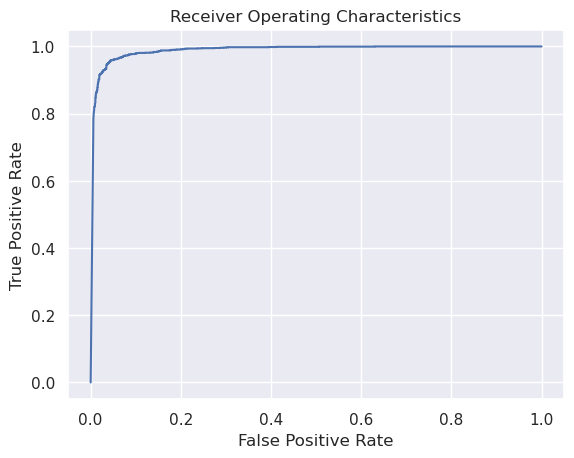

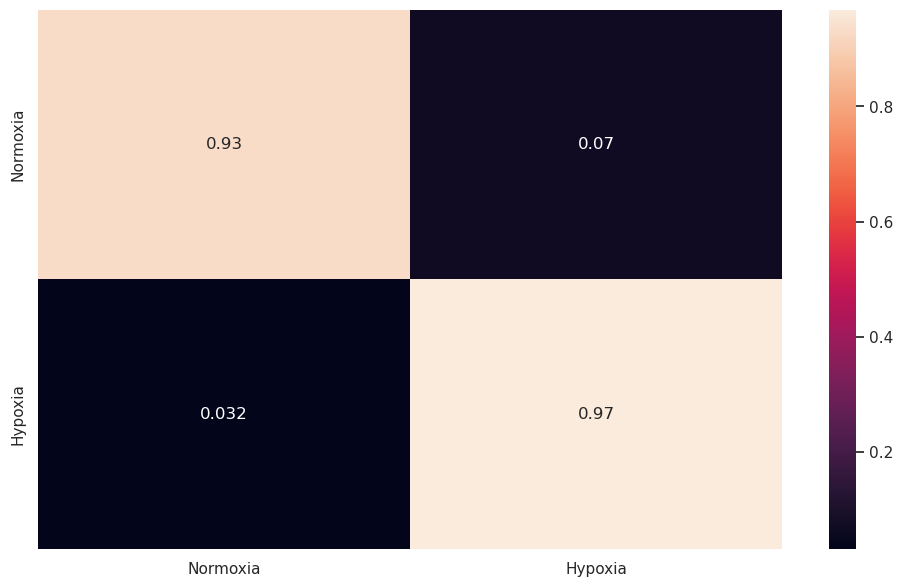

In [108]:
measure_model(model, test_loader_drop_hcc)

In [105]:
measure_model(model, test_loader_smart)

NameError: name 'test_loader_smart' is not defined

In [106]:

measure_model(model, test_loader_drop)

NameError: name 'test_loader_drop' is not defined

In [34]:
torch.save(model.state_dict(), "KAN_SMART_HCC_Small.checkpoint")

NameError: name 'model' is not defined

In [29]:
import gc

model.cpu()
del model, admw, ada, sgd, adm
gc.collect()
torch.cuda.empty_cache()

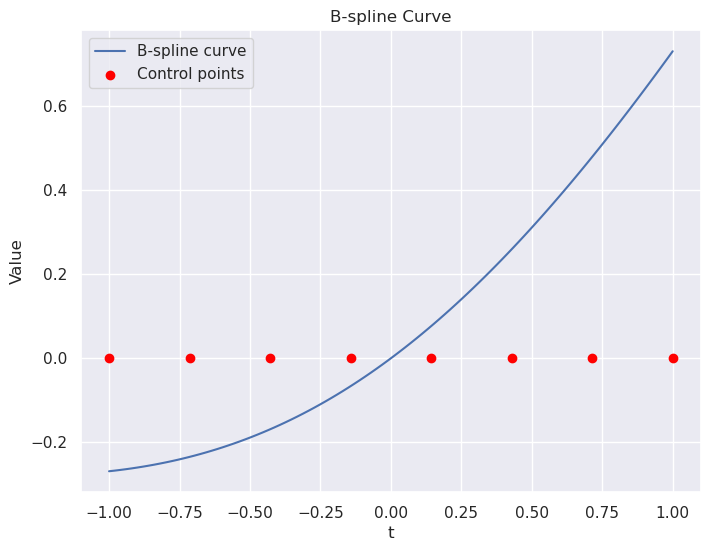

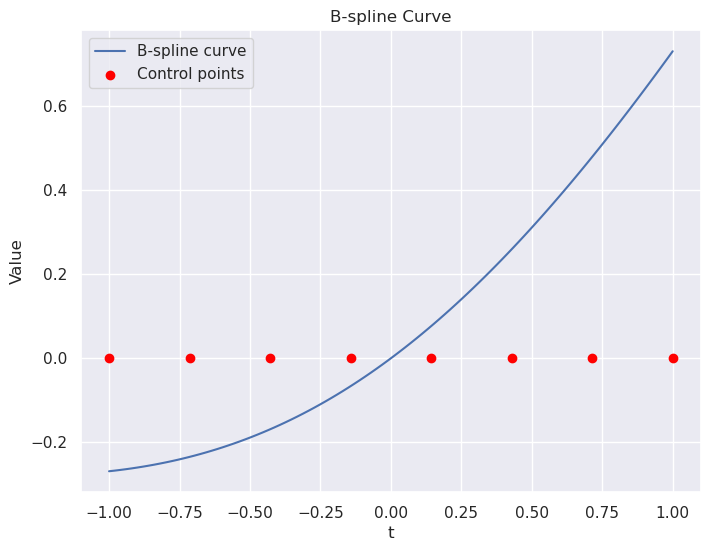

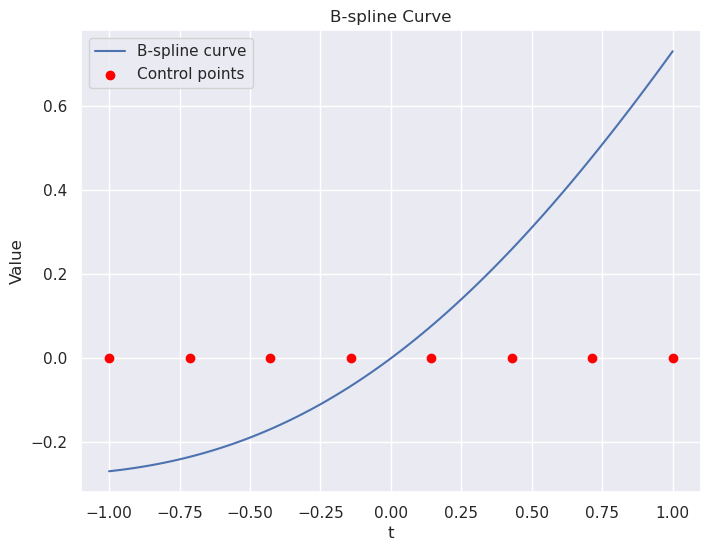

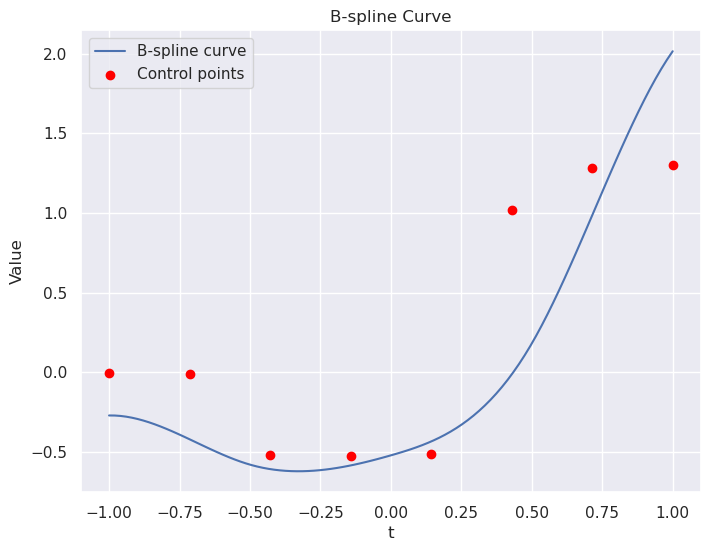

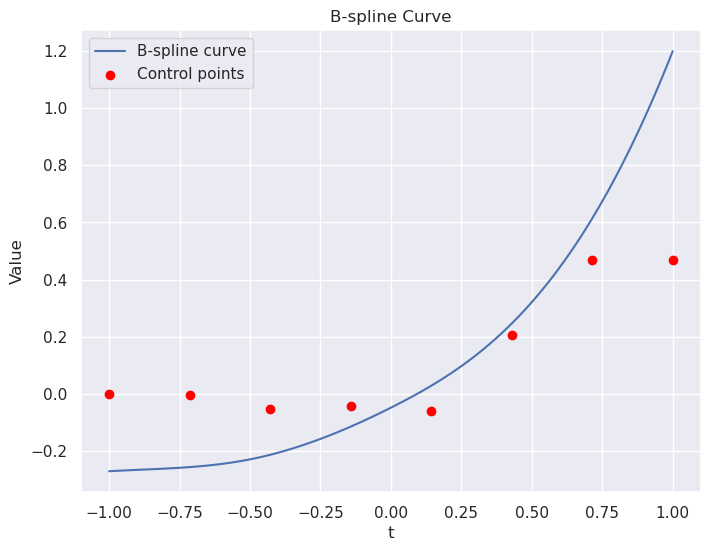

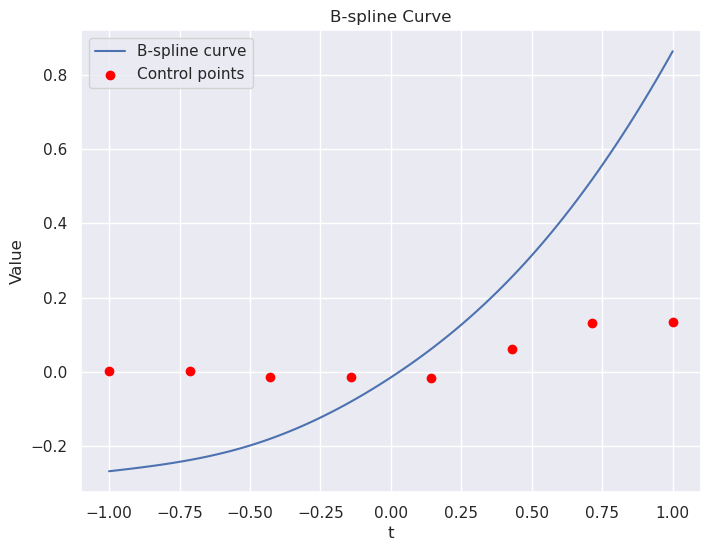

KeyboardInterrupt: 

In [72]:

from scipy.interpolate import BSpline
def visualize_kan(weight):
    # define B-spline parameters
    grid_size = 5
    spline_order = 3
    weights = weight

    # define knot vector
    knot_vector = np.concatenate(([-1] * spline_order, np.linspace(-1, 1, grid_size), [1] * spline_order))

    # define parameter range
    t = np.linspace(-1, 1, 100)

    # create B-spline object
    spline = BSpline(knot_vector, weights, spline_order)

    # calculate B-spline curve values
    spline_values = spline(t)
    
    # add bias
    silu = nn.SiLU()
    bias = silu(torch.tensor(t))
    
    spline_values = spline_values + bias.numpy()

    # plot B-spline curve
    plt.figure(figsize=(8, 6))
    plt.plot(t, spline_values, label='B-spline curve')
    plt.scatter(np.linspace(-1, 1, len(weights)), weights, color='red', label='Control points')
    plt.title('B-spline Curve')
    plt.xlabel('t')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

for layer in model.cpu().layers:
    if isinstance(layer, KANLinear):
        for i in range(1):
            for j in range(input_size):
                visualize_kan(layer.scaled_spline_weight[i][j].detach().numpy())